60it [00:01, 51.53it/s]

err: 1.15e+04, lr: 0.0139469 

117it [00:02, 79.15it/s]

err: 1.10e+04, lr: 0.0093651 , last batch: 64


160it [00:02, 74.09it/s]

err: 1.01e+04, lr: 0.0063104 , last batch: 32


210it [00:03, 67.84it/s]

err: 9.45e+03, lr: 0.0042739 , last batch: 16


261it [00:04, 60.73it/s]

err: 8.93e+03, lr: 0.0029160 , last batch: 8


306it [00:05, 53.96it/s]

err: 8.54e+03, lr: 0.0020108 , last batch: 4


355it [00:06, 50.24it/s]

err: 8.25e+03, lr: 0.0014072 , last batch: 2


405it [00:07, 36.12it/s]

err: 8.04e+03, lr: 0.0009934 , last batch: 2


455it [00:09, 26.38it/s]

err: 7.90e+03, lr: 0.0005927 , last batch: 1


500it [00:11, 45.11it/s]


best error: 7.83e+03


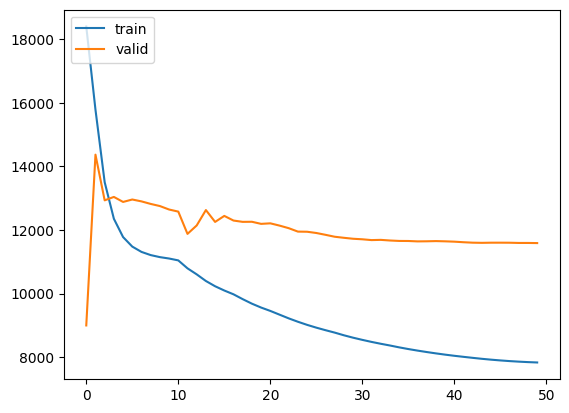

RCV stat	mean: 0.004, min: 0.0, max: 1.0
S stat	mean: 0.302, min: 0.0, max: 1.0
Positives stat	mean: 0.374, min: 0.046, max: 0.865
Others stat	mean: 0.300, min: 0.0, max: 1.0

        printing heatmap
        from left to right: 
        1. R_train, 
        2. S: inferred R, 
        3. value of S in places where R_train =1, 
        4. after applying threshold split
        5. RCV
        
last picture: whites are true positives, and blacks are false positives


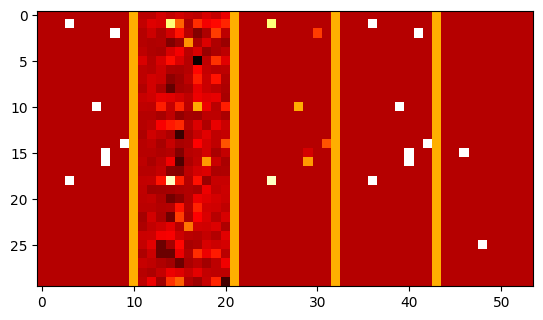

In [10]:
from util.data_reader import read_interaction_matrix
from mfactorization import matrix_factorization
from mfactorization.mf import error_pq, error

from matplotlib import pyplot as plt
import numpy as np


def split_train_valid(R, th=0.8):
    i, j = R.nonzero()
    n = i.shape[0]
    n_train = int(th * n)
    
    s = np.random.default_rng(1234).choice(n, n_train, False)

    M = np.zeros_like(R)
    M[(i[s], j[s])] = 1

    return M, R - M


def infer(q, p, th=0.6):
    
    S = q @ p.T
    S -= S.min()
    S /= S.max()
    
    return S

    U, I = q.shape[0], p.shape[0]
    M = np.zeros((U, I))
    M[S>th] = 1

    return M


def plot_mf_error(err, logs, RCV):

    def get_errors(logs):
        errors = [log[0] for log in logs]
        return errors

    print(f'best error: {err:.2e}')
    
    errors = get_errors(logs)
    plt.plot(errors, label='train')

    def get_qps(logs):
        return [(q,p) for (_, q,p) in logs]

    cv_errors = [error_pq(RCV, infer(*qp), *qp, reg=0.001) for qp in get_qps(logs)]
    
    plt.plot(4*np.array(cv_errors), label='valid')
    plt.legend(loc='upper left')
    plt.show()


def mf_recall(q, p, RCV, R):
    S = infer(q, p)

    a = list(zip(*RCV.nonzero()))
    b = list(zip(*S.nonzero()))

    found = len(set(a).intersection(b))
    all_pos = len(a) + R.nonzero()[0].shape[0]

    print(f'S+ {len(b)}\t RCV+ {len(a)}\t All+ {all_pos}')
    print(f'recall+ {found/len(a)*100:.2f}%\t found+ {found}')


def describe_result(q, p, RCV):
    def describe(M, name=None):

        def frmt(f):
            i = 5
            i += 1 if f < 0 else 0
            return str(f)[:i]

        print((f'{name}\t' if name else '') + f'mean: {frmt(M.mean())}, min: {frmt(M.min())}, max: {frmt(M.max())}')
   
    S = infer(q, p)

    describe(RCV, 'RCV stat')
    describe(S, 'S stat')
    describe(S[RCV.nonzero()], 'Positives stat')
    describe((S - S*RCV), 'Others stat')


def draw_retrieval_heatmap(q, p, R, RCV):

    from util import heatmap
    import numpy as np

    S = q @ p.T

    FP = np.zeros_like(S)
    FP[S > S.max() * 0.5] = -1
    FP[R.nonzero()] = 1

    P = S * R
    Z = S - (S * R)

    D = np.zeros((P.shape[0], 1))
    D[:,0] = 0.5

    # plotting R, S, P, FP alongside each other (showing only a window of them)
    t = tuple(M[60:90, 0:10] for M in (R, D, S, D, P, D, FP, D, RCV))
    V = np.concatenate(t, axis=1)

    print(
        '''
        printing heatmap
        from left to right: 
        1. R_train, 
        2. S: inferred R, 
        3. value of S in places where R_train =1, 
        4. after applying threshold split
        5. RCV
        '''
        )
    
    print("last picture: whites are true positives, and blacks are false positives")
    
    return heatmap(V)


R_main = read_interaction_matrix()

R, RCV = split_train_valid(R_main)

q, p, err, logs = matrix_factorization(
    R, lr=(2e-2, 2e-4), n_epochs=500, sampled_epochs=400, sample_size=0.05, return_err_log=True, save_logs=True
    )

plot_mf_error(err, logs, RCV)
describe_result(q, p, RCV)
draw_retrieval_heatmap(q, p, R, RCV)

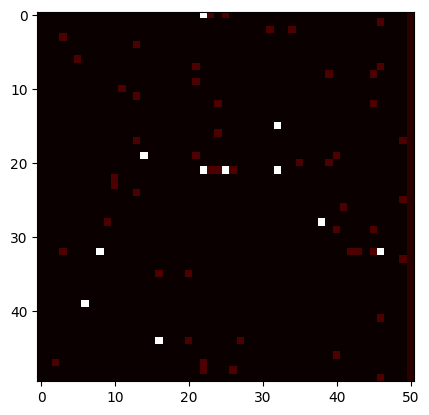

In [11]:
from util import heatmaps
heatmaps([(R + 10 * RCV)[0:50, 0:50]])